In [0]:
import io
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf
#from tensorflow import keras
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adagrad

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.image as mpimg

Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014

help from : https://www.tensorflow.org/tutorials/keras/regression

In [0]:
from google.colab import files
uploaded = files.upload()

Saving mayo-001.p to mayo-001 (1).p
Saving mayo-002.p to mayo-002 (1).p
Saving mayo-003.p to mayo-003 (1).p
Saving mayo-004.p to mayo-004 (1).p
Saving mayo-005.p to mayo-005 (1).p
Saving mayo-006.p to mayo-006 (1).p
Saving mayo-007.p to mayo-007 (1).p
Saving mayo-008.p to mayo-008 (1).p
Saving sansum-01.p to sansum-01 (1).p
Saving sansum-02.p to sansum-02 (1).p
Saving sansum-03.p to sansum-03 (1).p
Saving sansum-04.p to sansum-04 (1).p
Saving sansum-05.p to sansum-05 (1).p
Saving sansum-06.p to sansum-06.p
Saving sansum-07.p to sansum-07.p
Saving sansum-08.p to sansum-08.p
Saving sansum-09.p to sansum-09.p
Saving sansum-10.p to sansum-10.p


In [0]:
# patient suffixes for file names
mayo_suffs = ['001','002','003','004','005','006','007','008']
sans_suffs = ['01','02','03','04','05','06','07','08','09','10']
data_bypat = {} # holder for data seperated by patient

# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(io.BytesIO(uploaded[filename]))
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].fillna(data_bypat['s%s' % (s+1)].mean())
    data_bypat['s%s' % (s+1)] = data_bypat['s%s' % (s+1)].loc[:,:] # ['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0']
    
for m, suff in enumerate(mayo_suffs):
    filename = 'mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(io.BytesIO(uploaded[filename]))
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].fillna(data_bypat['m%s' % (m+1)].mean())
    data_bypat['m%s' % (m+1)] = data_bypat['m%s' % (m+1)].loc[:,:] #['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60','eda0','hr0','step0','t0','temp0']

In [0]:
data_bypat['m4'].columns

Index(['BG0', 'BG_PH', 'BGday_var', 'dBG30', 'dBG60', 'deda30', 'deda60',
       'dtemp30', 'dtemp60', 'eda0', 'edaday_var', 'hr0', 'step0', 't0',
       'temp0', 'tempday_var', 'step0mean_1hr', 'step0mean_2hr',
       'step0mean_3hr', 'step0mean_4hr', 'step0mean_5hr', 'hr0adj_curr',
       'hr0adj_mean_1hr', 'hr0adj_mean_2hr', 'hr0adj_mean_3hr',
       'hr0adj_mean_4hr', 'hr0adj_mean_5hr'],
      dtype='object')

In [0]:
# Generate 9 folds with random pairs of patients for cross validation
def get_folds(data):
    keynames = list(data.keys()) # get the key names that represent individual patients
    random.shuffle(keynames) # shuffle them into a random order
    folds = np.reshape(keynames, [9,2]) # pair them off into 9 folds
    return folds

In [0]:
## intakes training and test predictors, then scales them all down to be 0 mean and 1 variance (according to what is observed in training set)

def scale_data(xtrain,xtest):
    scaler = StandardScaler() # generate scaler
    xtrain.loc[:,:] = scaler.fit_transform(xtrain) # fit and transform on training
    xtest.loc[:,:] = scaler.transform(xtest) # naively transform test data without fitting to it
    return xtrain, xtest

In [0]:
### takes in the by patient data and the folds by which to seperate, outputs training features/labels and testing features/labels for the current fold being tested 
def get_train_test(data,folds,current_fold):
    ## get the test data
    
    # extract patients in current fold for testing
    test_data1 = data[folds[current_fold,0]]
    test_data2 = data[folds[current_fold,1]]
    # combine into one testing df and shuffle
    test_data = pd.concat([test_data1,test_data2],ignore_index=True).sample(frac=1)                                                                                                                                                                                                                                       
    # split into predictors and labels
    test_y = test_data['BG_PH']
    test_x = test_data.drop(columns=['BG_PH'])
    
    
    ## extract patients not in current fold for training
    
    # drop the testing fold and flatten the patient array for iteration
    train_pats = np.delete(folds,current_fold,axis=0).flatten()
    train_data = pd.DataFrame() # holder df for training data
    # combine into one training df and shuffle
    for pat in train_pats:
        train_data = pd.concat([train_data,data[pat]], ignore_index=True)
    train_data  = train_data.sample(frac=1)
    train_y = train_data['BG_PH']
    train_x = train_data.drop(columns=['BG_PH'])
    
    train_x, test_x = scale_data(train_x,test_x)
    
    return test_y, test_x, train_y, train_x

In [0]:
def get_RMSE(actual,predicted):
    return np.sqrt(np.mean((actual-predicted)**2))

In [0]:
def PCA_transform(train_x, test_x):
    train_x, test_x = scale_data(train_x, test_x)
    pca = PCA() # full PCA with no automatic truncation
    train_pca = pca.fit_transform(train_x) # fit the pca and transform the training values
    test_pca = pca.transform(test_x) # transform the test data without looking at it fr adjusting pca
    print(train_x.head())
    return train_pca, test_pca, pca.explained_variance_ratio_


In [0]:
#def test_networks(data,folds,)

folds = get_folds(data_bypat)

test_y, test_x, train_y, train_x = get_train_test(data_bypat,folds,1)
train_x, test_x, holder_ = PCA_transform(train_x,test_x)
train_x = pd.DataFrame(train_x[:,:15])
test_x = pd.DataFrame(test_x[:,:15])
# cross validation is handled within the keras model fitting
#train_x = train_x.append(test_x)
#train_y = train_y.append(test_y)
#train_x,test_x = scale_data(train_x,test_x)

model = Sequential([
    layers.Dense(32, activation='tanh', input_shape=[len(train_x.columns)]),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1) # output layer
])

# the method of optimization for the network
optimizer = Adagrad()

# compile the model together with its loss function and optimization approach
model.compile(
  loss='mse',
  optimizer=optimizer,
  metrics=['mse','mae'])

            BG0  BGday_var  ...  hr0adj_mean_4hr  hr0adj_mean_5hr
2884  -0.809906  -1.006524  ...        -0.419465        -0.287670
56151 -0.177244   2.976637  ...         2.050298         0.110198
7061  -0.208877   1.172333  ...        -1.205175        -2.311872
34249 -1.347669  -1.006882  ...         0.284691         0.516700
28962  1.578394   1.768667  ...        -2.181766        -0.051763

[5 rows x 26 columns]


In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                512       
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


In [0]:
train_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.408089,-2.368074,0.523010,0.416600,0.508171,-0.365818,0.856400,0.250670,-0.408402,0.281063,-0.487298,-0.267667,0.449603,-0.029765,0.076587
1,1.483986,-0.017345,-0.249375,-0.100146,-0.539672,0.277571,-1.840498,-0.221021,-0.001226,1.350619,-1.014519,-0.710444,0.012332,2.256418,0.057127
2,-2.810251,0.855681,0.950759,0.534055,0.172819,-2.004430,-0.777692,-0.324135,-0.144895,0.353388,-0.267347,-0.348952,0.387443,1.283227,0.146734
3,2.541912,1.403678,0.093143,0.452711,3.534974,0.268659,2.174503,-0.233595,3.194829,-1.321622,0.516093,0.393260,0.635407,-0.242229,1.429297
4,-4.181059,0.794913,-1.441060,0.172965,-0.882165,0.719073,-1.969925,-0.662306,-0.079475,0.168024,0.862766,0.121931,-0.058322,0.316839,0.524390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94227,-2.046408,0.585699,1.282170,-4.783171,2.066678,0.831192,-1.811284,-0.225052,0.503018,1.317900,-0.219458,-0.145230,-0.089264,-0.037975,-0.253354
94228,2.787527,1.094445,1.907802,0.267081,-1.055145,0.342881,-0.824018,0.112812,0.109479,-1.298074,0.030266,0.202117,0.845776,0.107561,-0.202801
94229,2.197701,0.659338,-0.088105,-0.929837,0.293179,-0.261142,1.143760,0.042148,-0.666877,0.980922,-1.104872,0.157815,0.414075,-0.572063,-0.193219
94230,-0.977008,0.890280,-1.135762,-3.133869,1.402935,1.081427,1.464800,0.109980,-0.122180,-0.258980,-0.274182,0.101107,-0.524832,0.325574,0.020349


In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


history = model.fit(
  train_x, train_y,
  epochs=500, # train on dataset 1000 times
  validation_split = .2, # needed to determine reasonable epoch size where learning stops
  verbose=0, # dont output progress bar
  shuffle=True,# shuffle data each epoch
  callbacks = [PrintDot()]) # track progress


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

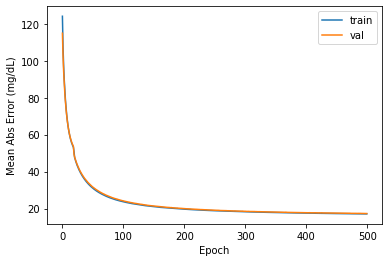

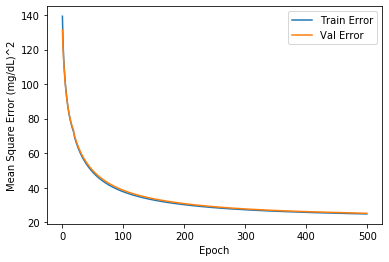

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error (mg/dL)')
  plt.plot(hist['epoch'], hist['mean_absolute_error'])
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'])
  plt.legend(['train','val'])

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error (mg/dL)^2')
  plt.plot(hist['epoch'], hist['mean_squared_error']**.5,
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error']**.5,
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [0]:
hist

,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,epoch
0,17275.067599,17275.067599,114.877221,19415.655611,19415.655611,124.067976,0
1,14622.163892,14622.163892,102.821010,15496.073365,15496.073365,107.350074,1
2,12892.195864,12892.195864,94.235642,13382.021967,13382.021967,97.201692,2
3,11603.232120,11603.232120,87.466454,11910.419392,11910.419392,89.618799,3
4,10587.601574,10587.601574,81.927076,10782.409165,10782.409165,83.532348,4
...,...,...,...,...,...,...,...
495,635.284631,635.284631,17.375950,616.607220,616.607220,17.122255,495
496,634.973875,634.973875,17.325332,616.286145,616.286145,17.126217,496
497,634.595472,634.595472,17.337049,615.964811,615.964811,17.117106,497
498,633.934924,633.934924,17.352322,615.561886,615.561886,17.110306,498


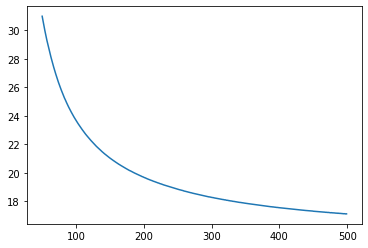

In [0]:
plt.plot(hist.loc[50:,'epoch'],hist.loc[50:,'mean_absolute_error'])

In [0]:
rmse = np.sqrt(hist['val_mean_squared_error'])
train_rmse = np.sqrt(hist['mean_squared_error'])

In [0]:
np.min(rmse)

25.172138576269393

In [0]:
np.min(train_rmse)

24.80292749792569

In [0]:
def CEG_analysis(measured,predicted):
    
    ## determine which points fall in each region
    
    a_measured = measured.loc[(abs(measured-predicted)<=.2*measured) | ((measured<=70)&(predicted<=70))]
    a_predicted = predicted.loc[(abs(measured-predicted)<=.2*measured) | ((measured<=70)&(predicted<=70))]
    
    e_measured = measured.loc[((measured<=70)&(predicted>180)) | ((measured>180)&(predicted<=70))]
    e_predicted = predicted.loc[((measured<=70)&(predicted>180)) | ((measured>180)&(predicted<=70))]
    
    # make sure to exclude a conditions
    d_measured = measured.loc[(((predicted>70)&(predicted<=180)) & ((measured<=70)|(measured>240))) & ~(abs(measured-predicted)<=.2*measured)]
    d_predicted = predicted.loc[(((predicted>70)&(predicted<=180)) & ((measured<=70)|(measured>240))) & ~(abs(measured-predicted)<=.2*measured)]
    
    c_measured = measured.loc[(((predicted<=70)&(measured<=180))&(predicted<7/5*(measured-130))) | (((predicted>180)&(measured<predicted-110))&(measured>70))]
    c_predicted = predicted.loc[(((predicted<=70)&(measured<=180))&(predicted<7/5*(measured-130))) | (((predicted>180)&(measured<predicted-110))&(measured>70))]
    
    not_b_inds_measured = np.concatenate([a_measured.index.values,c_measured.index.values,d_measured.index.values,e_measured.index.values])
    not_b_inds_predicted = np.concatenate([a_predicted.index.values,c_predicted.index.values,d_predicted.index.values,e_predicted.index.values])
    print(np.shape(not_b_inds_measured))
    print(type(not_b_inds_measured))
    print(type(a_measured.index.values))
    print(a_measured.index.values)
    b_measured = measured.drop(index=not_b_inds_measured)
    b_predicted = predicted.drop(index=not_b_inds_predicted)

    
    ## get the percent in each region
    
    a_per = 100*len(a_measured)/len(measured)
    b_per = 100*len(b_measured)/len(measured)
    c_per = 100*len(c_measured)/len(measured)
    d_per = 100*len(d_measured)/len(measured)
    e_per = 100*len(e_measured)/len(measured)
    
    
    ## do the plotting
    
    ceg = mpimg.imread('CEG400_clean.jpg')
    
    plt.figure(figsize=[10,10])
    plt.imshow(ceg,extent=[0,400,0,400])
    plt.scatter(e_measured,e_predicted,c='#c90d00')
    plt.scatter(d_measured,d_predicted,c='#ff4c40')
    plt.scatter(c_measured,c_predicted,c='#ff8880')
    plt.scatter(b_measured,b_predicted,c='#93ff82')
    plt.scatter(a_measured,a_predicted,c='#28c410')
    
    
    
    
    
    plt.title('CEG Analysis', fontsize=22)
    plt.xlabel('Measured BG (mg/dL)', fontsize=22)
    plt.ylabel('Predicted BG (mg/dL)', fontsize=22)
    plt.xlim([0,400])
    plt.ylim([0,400])
    plt.legend(['E','D','C','B','A'], fontsize=22)
    
    return [a_per,b_per,c_per,d_per,e_per]

In [0]:
test_y_pred = test_y.copy()
test_y_pred.loc[:]= model.predict(test_x).squeeze()

In [0]:
uploaded_ = files.upload()

MessageError: ignored

(10552,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[10722  7507  6778 ... 10223    15  7720]


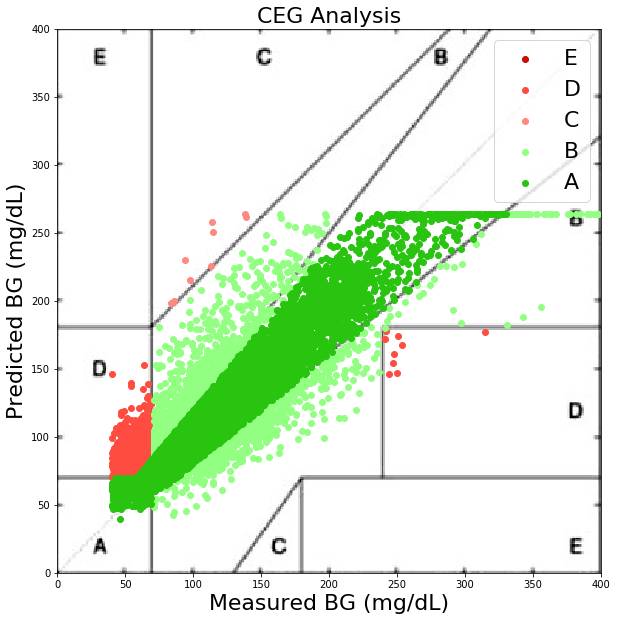

In [0]:
props = CEG_analysis(test_y,pd.Series(test_y_pred.squeeze()))

In [0]:
test_y_pred.squeeze().shape

(11869,)

In [0]:
len(pd.Series(test_y_pred.squeeze()))

11869

In [0]:
len(train_y)

94749

In [0]:
np.max(train_y)

403.5

In [0]:
props

[71.95214424130087,
 20.473502401213246,
 0.07582778667116016,
 7.498525570814728,
 0.0]

In [0]:
props[0]+props[1]

92.42564664251412

In [0]:
train_x.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04,9.474900e+04
mean,6.107170e-18,-1.435557e-17,-9.748974e-19,-2.301320e-17,6.946144e-18,1.382960e-18,-1.728275e-17,-9.377822e-18,-5.655753e-18,-1.787859e-17,-1.703141e-18,-2.824273e-17,1.699040e-20,6.976683e-18,1.593172e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-3.838734e+00,-1.594262e+00,-4.416652e+00,-9.850083e+00,-4.164311e+00,-9.033554e+00,-5.914007e+00,-3.873858e+00,-1.417005e+01,-4.572800e+00,-8.359852e+00,-8.650813e+00,-8.982661e+00,-4.555207e+00,-1.191443e+01
25%,-5.334309e-01,-6.557915e-01,-5.123457e-01,-3.787143e-01,-5.437196e-01,-5.868924e-01,-5.470581e-01,-2.393427e-01,-3.576954e-01,-7.168960e-01,-5.566872e-01,-2.484947e-01,-4.722608e-01,-6.254472e-01,-3.772080e-01
50%,-7.046497e-02,-1.083847e-01,-4.556017e-02,1.722653e-01,-1.413189e-01,-2.574357e-02,1.516904e-01,-5.042341e-02,-7.031800e-02,1.378451e-01,-1.015703e-01,1.361380e-02,-1.278815e-03,-1.045301e-01,8.751400e-03
75%,4.317008e-01,4.542783e-01,4.223313e-01,5.380701e-01,3.486405e-01,5.381290e-01,6.811210e-01,1.021956e-01,2.283087e-01,7.140815e-01,4.404797e-01,3.265483e-01,4.415271e-01,4.821777e-01,3.573469e-01
max,8.405027e+00,1.094945e+01,1.401777e+01,1.369698e+01,1.981992e+01,9.138305e+00,6.436469e+00,2.426133e+01,2.407868e+01,7.190965e+00,1.170930e+01,1.833887e+01,1.346695e+01,9.795435e+00,1.984091e+01


In [0]:
test_x.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000,11869.000000
mean,-0.168089,0.022882,-0.234795,-0.126036,0.072914,0.024575,-0.191120,-0.124819,-0.093786,0.050621,-0.225774,0.030790,0.036854,0.285133,-0.063050
std,0.798641,0.692169,0.667267,0.971529,0.827492,0.840822,0.915648,0.253069,0.518658,0.943389,0.590123,0.431781,0.806077,1.130014,0.682387
min,-3.213460,-1.458346,-3.627311,-7.971293,-2.041723,-5.092495,-3.661089,-1.942928,-6.949328,-3.670874,-2.851859,-1.523976,-5.922958,-2.950949,-5.087506
25%,-0.652386,-0.393446,-0.636785,-0.507743,-0.464948,-0.477972,-0.733524,-0.270942,-0.359868,-0.623108,-0.616604,-0.270162,-0.410045,-0.477443,-0.341030
50%,-0.176515,-0.011677,-0.250031,0.126880,-0.113471,0.083533,-0.095796,-0.096758,-0.080166,0.177671,-0.256259,-0.010171,0.053976,0.171894,-0.011163
75%,0.301233,0.389934,0.147644,0.514748,0.423998,0.570572,0.460192,0.052801,0.176802,0.772258,0.127339,0.325903,0.501310,0.895399,0.291434
max,4.245556,5.041759,5.857623,5.817264,9.710084,7.311160,2.587212,1.760378,7.321056,2.314282,4.260386,3.073719,4.711521,4.886580,10.940391
